In [1]:
import helpers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
def get_agents(n: int, with_comm: bool):
    env = helpers.create_envs(n=1, yamls_filename=f'yamls/{n}_region_yamls')[0]
    agents = helpers.create_agents(env)
    for agent in agents:
        agent.load(f"runs/{n}/{'with' if with_comm else 'no'}_comm", negotiating=with_comm)
    return agents

In [3]:
def get_eval_rewards(n: int, with_comm: bool):
    rs = np.load(f"runs/{n}/{'with' if with_comm else 'no'}_comm/stoch.npy")
    dfs= [pd.DataFrame(rs[..., i]).T.melt(var_name='epoch', value_name='cum_return') for i in range(n)]
    return dfs

In [4]:
def get_env(n):
    return helpers.create_envs(n=1, yamls_filename=f'yamls/{n}_region_yamls')[0]

In [5]:
def get_baseline(n):
    return np.load(f'baseline/rs{n}.npy')

In [6]:
def ci(x, value = .95):
    mean = x.mean()
    interval = value * x.std() / np.sqrt(len(x))
    return mean - interval, mean + interval

In [7]:
def plot_returns(n):
    
    fig, ax = plt.subplots(1, n, sharey=True)
    returns_no_comm = get_eval_rewards(n, with_comm=False)
    returns_with_comm = get_eval_rewards(n, with_comm=True)
    baseline = get_baseline(n)
    # baseline_ci = ci(baseline)
    for i in range(n):
        sns.lineplot(data=returns_no_comm[i], x='epoch', y='cum_return', ax=ax[i], label='no_comm', legend=False)
        sns.lineplot(data=returns_with_comm[i], x='epoch', y='cum_return', ax=ax[i], label='with_comm', legend=False)
        ax[i].axhline(baseline.mean(), c = 'g', linestyle = '--', label = 'baseline', xmin = .05, xmax = .95)
        # ax[i].fill_between(x = np.arange(201), y1 = baseline_ci[0], y2 = baseline_ci[1], color = 'g', alpha = .15, label = '95% CI')
        ax[i].set_title(f'Agent{i}')
        ax[i].set_xlabel('Epoch')
        ax[i].set_ylabel('Cumulative return')
    handles, labels = ax[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol = 4, borderaxespad=-0.5)
    fig.suptitle(f'Validation returns for all agents during training with stochastic policies \n in an environment with {n} agents')
    plt.tight_layout()
    plt.show()

In [8]:
# plot_returns(4)

In [86]:
def get_eval_rs():
    try:
        rs = np.load('final_eval_rs.npy')
    except Exception as e:
        agents = [{'with_comm' : get_agents(i, True), 'no_comm': get_agents(i, False)} for i in (2,3,4)]
        envs = [get_env(i) for i in (2, 3, 4)]
        evals = [(helpers.eval_agents_final(a['no_comm'], e, with_comm=False), 
                  helpers.eval_agents_final(a['with_comm'], e, with_comm=True)) 
                 for a, e in zip(agents, envs)]
        rs = np.stack([(e[0], e[1][0]) for e in evals])
        np.save('final_eval_rs.npy', rs)
    dfs = [pd.DataFrame(r.T, columns=['no', 'with']) for r in rs]
    for i, df in enumerate(dfs, start=2):
        df['baseline'] = get_baseline(i)
    return dfs

In [87]:
rs = get_eval_rs()

In [88]:
for i, r in enumerate(rs, start = 2):
    r['n'] = i
df = pd.concat(rs).melt(id_vars = 'n', var_name='negotiation')

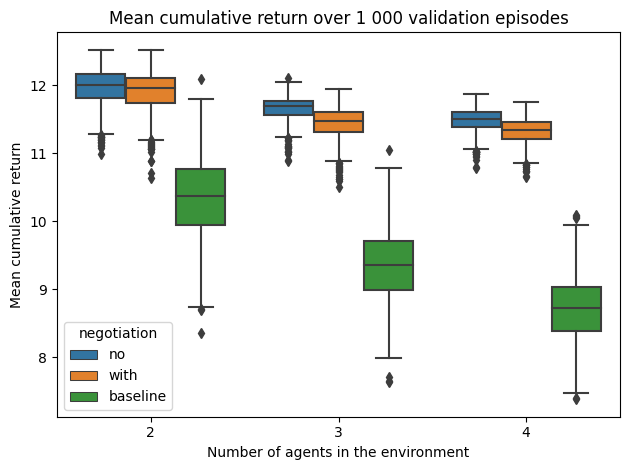

In [92]:
sns.boxplot(df, x='n', y='value', hue = 'negotiation')
plt.xlabel('Number of agents in the environment')
plt.ylabel('Mean cumulative return')
plt.title('Mean cumulative return over 1 000 validation episodes')
plt.tight_layout()
plt.show()